In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../')

In [15]:
#tasks = ["mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "wnli", "cola", "SQuAD", "stsb"]
#tasks = ["mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "wnli", "cola", "stsb"]
tasks = ["sst2", "mrpc", "qnli", "qqp", "rte", "sst2", "wnli"]
# The steps here mean (save steps, max steps)
#steps = [(200, 10000), (500, 18000)]
steps = [(200, 10000)]
#steps = [(500, 18000)]
rand_seeds = [2,3]

In [16]:
class arguments:
    "Argument class"
    
    def __init__(self):
        self.directory_depth = 1 # the 'visualization' folder is one level down from the root directory
        self.dataset = 'IWSLT' # choice ['IWSLT', 'WMT']
        self.training_type = 'normal' # choice ['const_lr', 'normal']
        self.experiment_type = 'width' # choice ['sample', 'lr']
        self.second_exp = False
        self.mkdir = False
        self.IWSLT_width = 128
        self.only20 = False

In [17]:
def check_epochs(mypath):
    
    folders = os.listdir(mypath)
    epochs = []
    for folder in folders:
        if 'checkpoint-' in folder:
            epochs.append(int(folder[11:]))
    epochs.sort()
    return epochs

def get_alpha(dict0):
    return dict0['summary']['alpha']

{'L2': -0.268940884909771, 'L2_DIST': 0.27611865258924084, 'INVERSE_MARGIN': -0.3227149321266969, 'LOG_PROD_OF_SPEC': 0.06333192189454365, 'LOG_SUM_OF_SPEC': 0.06323094387994455, 'LOG_PROD_OF_SPEC_OVER_MARGIN': -0.3166163901458019, 'LOG_SPEC_INIT_MAIN': -0.44170492279525136, 'LOG_SPEC_ORIG_MAIN': -0.316606334841629, 'LOG_SUM_OF_SPEC_OVER_MARGIN': -0.3166163901458019, 'LOG_PROD_OF_FRO': 0.10713693577421932, 'LOG_SUM_OF_FRO': 0.10715313188818712, 'LOG_PROD_OF_FRO_OVER_MARGIN': -0.31816101981034395, 'LOG_SUM_OF_FRO_OVER_MARGIN': -0.31816101981034395, 'FRO_DIST': 0.27611865258924084, 'DIST_SPEC_INIT': 0.28096530920060325, 'PARAM_NORM': -0.26901689338546964, 'alpha': -0.09951734539969831, 'entropy': -0.018647561588738086}


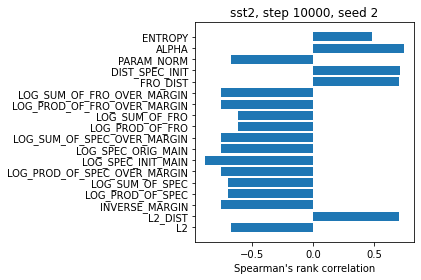

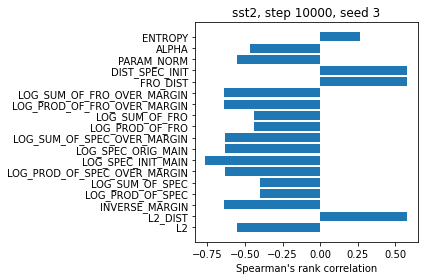

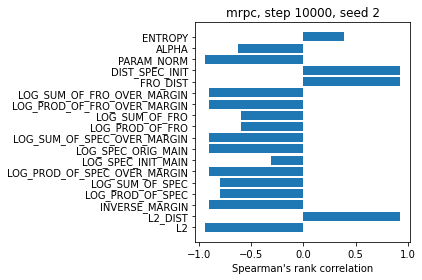

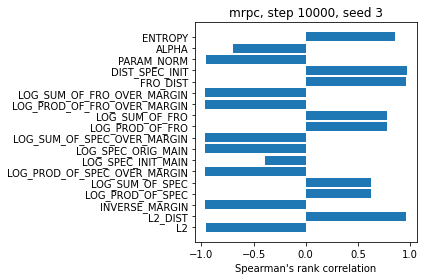

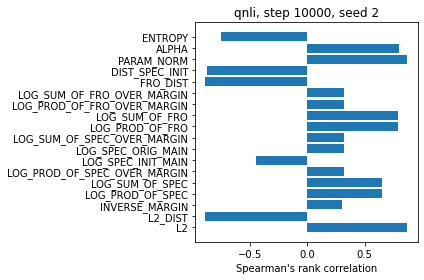

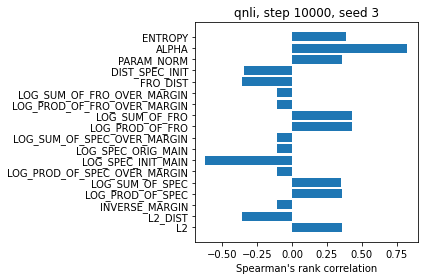

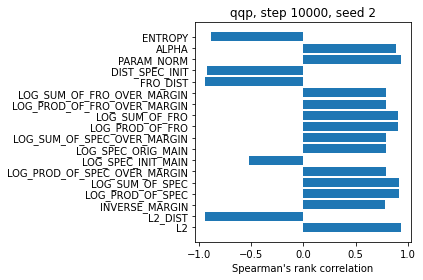

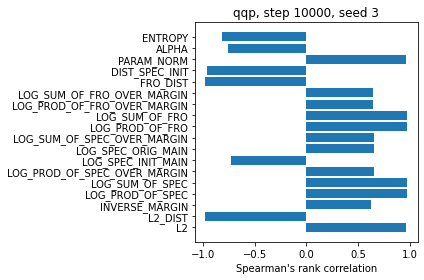

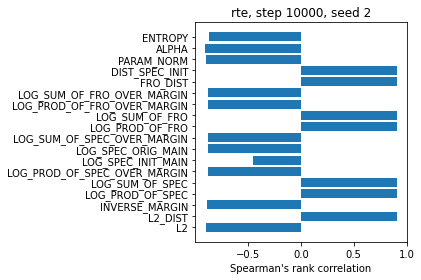

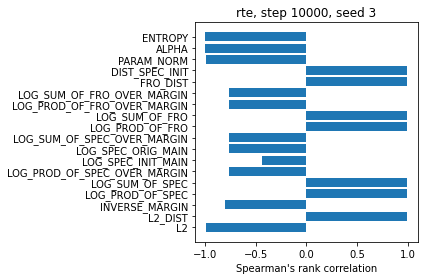

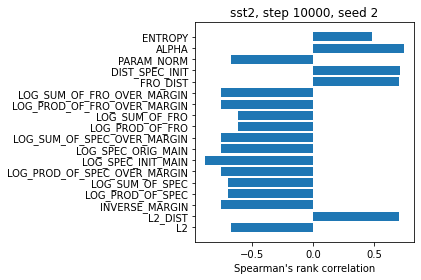

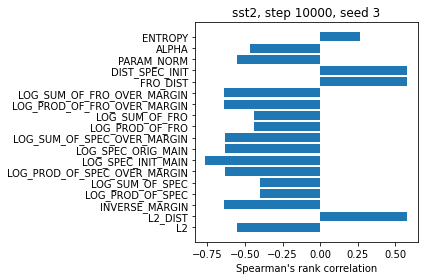

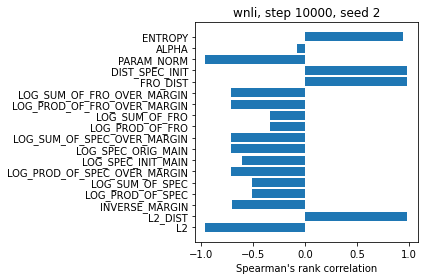

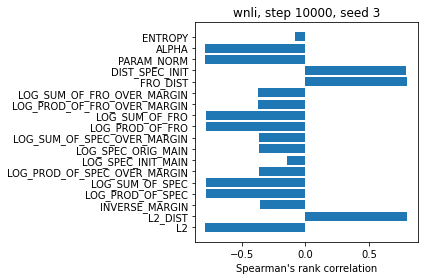

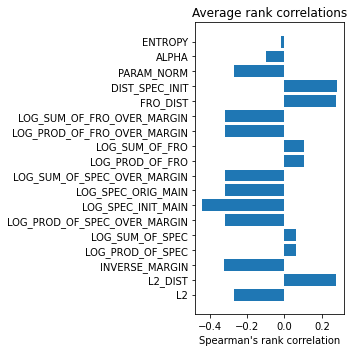

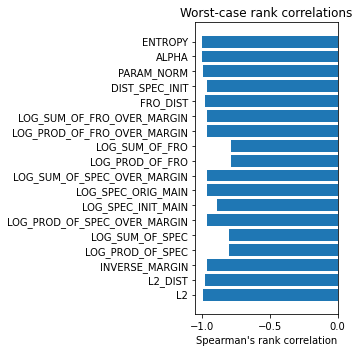

In [18]:
from utils.utils_ww_results import get_ww_layer_feature, compute_alpha_from_Ds, get_alphas_Ds, get_ww_alpha
from utils.utils_ww_results import get_ww_alpha_from_Ds, get_ww_layer_alpha, get_ww_result, get_ww_layer_metrics
from utils.utils_ww_results import get_per_layer_curves_one_epoch, get_all_layers, get_all_layers_square

from utils.utils_analyze_plots import change_dict_form, compute_correlation_single, compute_rank_correlation 
from utils.utils_analyze_plots import create_plot_result, aggregate_rank_correlations, average_rank_correlations, plot_rank_correlations 


keys = ['log_norm', 'alpha', 'alpha_weighted', 'log_alpha_norm', 'log_spectral_norm', 'stable_rank']
#single_features = ['rand_distance', 'entropy', 'bulk_mean_vec_entropy', 'bulk_var_vec_entropy', 'tail_mean_vec_entropy', 'tail_var_vec_entropy', 'exponent']
single_features = ['entropy', ]
exclude_metrics = ['FRO_OVER_SPEC', 'PARAMS', 'alpha']

rank_correlations_min = {}
rank_correlations_ave = {}

for task in tasks:
    for save_steps, max_steps in steps:
        for rand_seed in rand_seeds:
            
            fig, ax = plt.subplots()
            
            args = arguments()
            args.dataset = task
            #args.correlation_type = 'pearsonr'
            args.correlation_type = 'spearmanr'
            
            
            ckpt_folder = f'../../checkpoint/{task}/pretrain_ALBERT_lr_2e-5_wd_0.01_save_steps' \
                    + f'_{save_steps}_max_steps_{max_steps}_randlayer_{rand_seed}/'
            epochs = np.arange(0,max_steps+1,save_steps)
            alphas = []
            
            result_loss = os.path.join(ckpt_folder, 'final_eval.pkl')
            dict_loss = pickle.load(open(result_loss, 'rb'))
            loss = [dict_loss[epoch]['eval_loss'] for epoch in epochs]
            
            mypath = os.path.join(ckpt_folder, 'robust_measures.pkl')
            different_metrics = change_dict_form(mypath)
            
            plot_result = create_plot_result(keys, single_features, exclude_metrics)
            plot_result['eval_loss'] = loss
            
            for epoch in epochs:
                ww_result1 = os.path.join(ckpt_folder, f'checkpoint-{epoch}', 'ww_results.pkl')
                get_ww_result(plot_result, ww_result1, keys, get_alpha_from_Ds=False)
                #dict0 = pickle.load(open(result_ww, 'rb'))
                #alphas.append(get_alpha(dict0))
                
                ww_result2 = os.path.join(ckpt_folder, f'checkpoint-{epoch}', 'ww_results.pkl')
                for key in single_features:
                    plot_result[key].append( np.mean(get_ww_layer_feature(ww_result2, key=key)))
                        
            rank_correlations = compute_rank_correlation(plot_result, different_metrics, exclude_metrics = exclude_metrics,
                        correlation_type = args.correlation_type, 
                        single_features=single_features, reference_score='eval_loss')
                        #single_features=['exp_dist_exponent','lognormal_sigma']+single_features)
            
            aggregate_rank_correlations(rank_correlations, rank_correlations_min, rank_correlations_ave)  
            
            plot_rank_correlations(rank_correlations, ax)
            
            ax.set_title(f"{args.dataset}, step {max_steps}, seed {rand_seed}")
            if args.correlation_type == 'pearsonr':
                ax.set_xlabel('Pearson correlation')
            elif args.correlation_type == 'spearmanr':
                ax.set_xlabel("Spearman's rank correlation")
            #ax.set_xticklabels(plot_keys, rotation=90)
            
            plt.tight_layout()
            plt.savefig(f"results/Rank_correlation_{args.dataset}_step_{max_steps}_seed_{rand_seed}.pdf")
            
average_rank_correlations(rank_correlations_ave)

print(rank_correlations_ave)

# Plot average rank correlations
figs, ax = plt.subplots(1,1,figsize=(5,5))
plot_rank_correlations(rank_correlations_ave, ax)

ax.set_title(f"Average rank correlations")
if args.correlation_type == 'pearsonr':
    ax.set_xlabel('Pearson correlation')
elif args.correlation_type == 'spearmanr':
    ax.set_xlabel("Spearman's rank correlation")
plt.tight_layout()
plt.savefig(f"results/Average_rank_correlations.pdf")

# Plot min rank correlations
figs, ax = plt.subplots(1,1,figsize=(5,5))
plot_rank_correlations(rank_correlations_min, ax)

ax.set_title(f"Worst-case rank correlations")
if args.correlation_type == 'pearsonr':
    ax.set_xlabel('Pearson correlation')
elif args.correlation_type == 'spearmanr':
    ax.set_xlabel("Spearman's rank correlation")
plt.tight_layout()
plt.savefig(f"results/Worst_case_rank_correlations.pdf")
